In [ ]:
from google.colab import files
uploadFolder = files.upload()


Saving Satellite Image Classification.zip to Satellite Image Classification.zip


In [ ]:
import zipfile
import os

datasetZip = "Satellite Image Classification.zip"
extractFolder = "/content/Satellite Image Classification"

with zipfile.ZipFile(datasetZip, 'r') as zip_ref:
  zip_ref.extractall(extractFolder)

print("Dataset Extracted Succesfully")

Dataset Extracted Succesfully


In [ ]:
satelliteDatasetPath = "/content/Satellite Image Classification/data"

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
import os

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
satelliteImgHeight = 128
satelliteImgWidth = 128

In [ ]:
rawTrainData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                 subset = "training",
                                                                 seed = 42,
                                                                 image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                 label_mode = "categorical",
                                                                 validation_split = 0.20,
                                                                 batch_size = 64
                                                                )
rawValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  )

AUTOTUNE = tf.data.AUTOTUNE

satelliteTrainingData = rawTrainData.cache().shuffle(1000).prefetch(AUTOTUNE)

satelliteValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  ).cache().prefetch(AUTOTUNE)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [ ]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

satelliteTrainAugmented = satelliteTrainingData.map(lambda i, j: (dataAugmentation(i), j))
# satelliteTrainAugmented

In [ ]:
satelliteNormalizationLayer = tf.keras.layers.Rescaling(1./255)

In [ ]:
satelliteTrainNorm = satelliteTrainAugmented.map(lambda i, j: (satelliteNormalizationLayer(i), j))
satelliteValidationNorm = satelliteValidationData.map(lambda i, j: (satelliteNormalizationLayer(i), j))

In [ ]:
autotune = tf.data.AUTOTUNE

satelliteTrainPrefetch = satelliteTrainNorm.prefetch(buffer_size = autotune).shuffle(buffer_size = 64)
satelliteValidationPrefetch = satelliteValidationNorm.prefetch(buffer_size = autotune)

In [ ]:
classNames = satelliteTrainingData.class_names
classNames

['cloudy', 'desert', 'green_area', 'water']

In [ ]:
labels = []
for _, label in satelliteTrainNorm:
    # Convert one-hot to class index
    labels.extend(np.argmax(label.numpy(), axis = 1))

# Count Occurrences of each class
labelCounts = Counter(labels)
print(labelCounts)

# Print class-wise count
for ind, count in labelCounts.items():
    print(f"{classNames[ind]}: {count}")

Counter({0: 1233, 3: 1183, 2: 1182, 1: 907})
cloudy: 1233
water: 1183
green_area: 1182
desert: 907


In [ ]:
classWeights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(labels),
    y = labels
)

classWeightDict = {i : classWeights[i] for i in range(len(classWeights))}
print(f"Computed Class Weights: {classWeightDict}")

Computed Class Weights: {0: 0.9134225466342255, 1: 1.2417309812568909, 2: 0.952834179357022, 3: 0.952028740490279}


In [ ]:
checkpointPath = "/content/MobileNetV2_BestModel.keras"

In [ ]:
# Define Checkpoint Callback (Saves the Best Model)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpointPath,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)

# Define Early Stopping
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

# Define the Learning Rate Scheduler
lrScheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6,
    verbose = 1
)


In [ ]:
baseModel = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (satelliteImgHeight, satelliteImgWidth, 3))
baseModel.trainable = False

cnnModel = keras.Sequential([
    baseModel,
    GlobalAveragePooling2D(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(len(classNames), activation = "softmax", dtype = tf.float32)
])

In [ ]:
cnnModel.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
modelHistory = cnnModel.fit(
    satelliteTrainPrefetch,
    validation_data = satelliteValidationPrefetch,
    epochs = 70,
    class_weight = classWeightDict,
    callbacks = [checkpointCallback, earlyStopping, lrScheduler]
)

Epoch 1/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.7594 - loss: 0.6204
Epoch 1: val_loss improved from inf to 0.09014, saving model to /content/MobileNetV2_BestModel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7610 - loss: 0.6167 - val_accuracy: 0.9796 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 2/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.9518 - loss: 0.1531
Epoch 2: val_loss improved from 0.09014 to 0.05058, saving model to /content/MobileNetV2_BestModel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9518 - loss: 0.1530 - val_accuracy: 0.9893 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 3/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9543 - loss: 0.1442
Epoch 3: val_loss improved from 0.05058 to 0.04229, saving model to /content/MobileNetV2_BestModel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9544 - loss: 0.1440 - val_accuracy: 0.9902 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 4/70


In [ ]:
# Load the Best Model After Training
if os.path.exists(checkpointPath):
    print("Loading Best Model...")
    cnnModel = tf.keras.models.load_model(checkpointPath)

Loading Best Model...


In [ ]:
cnnModel.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,438 (10.50 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,970 (1.25 MB)

In [ ]:
lossScore, accuracyScore = cnnModel.evaluate(satelliteValidationPrefetch)
print(f"Validation Loss: {lossScore:.2%}")
print(f"Validation Accuracy: {accuracyScore:.2%}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 852ms/step - accuracy: 0.9938 - loss: 0.0221
Validation Loss: 2.61%
Validation Accuracy: 99.20%


In [ ]:
trueLabels = []
predictedLabels = []

for images, labels in satelliteValidationPrefetch:
    pred = cnnModel.predict(images)
    predictedLabels.extend(np.argmax(pred, axis = 1))
    trueLabels.extend(np.argmax(labels.numpy(), axis = 1))

confusionMatrix = confusion_matrix(trueLabels, predictedLabels)
print(confusionMatrix)

fig = px.imshow(confusionMatrix,
                labels = dict(x = "Predicted", y = "Actual", color = "Count"),
                x = rawTrainData.class_names,
                y = rawTrainData.class_names,
                text_auto = True,
                title = "Confusion Matrix"
               )
fig.update_layout(width = 500, height = 400)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[267   0   0   0]
 [  0 224   0   0]
 [  0   0 315   3]
 [  0   0   6 311]]


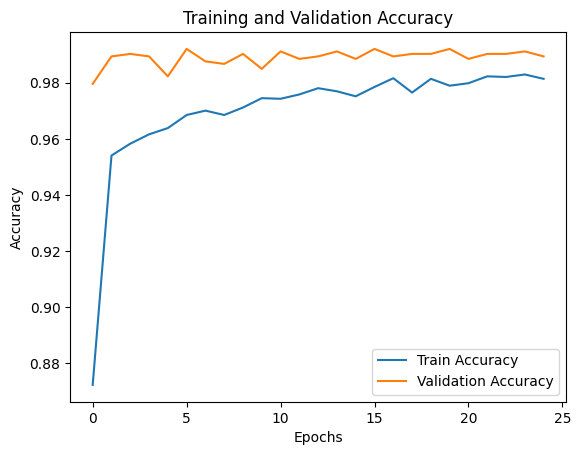

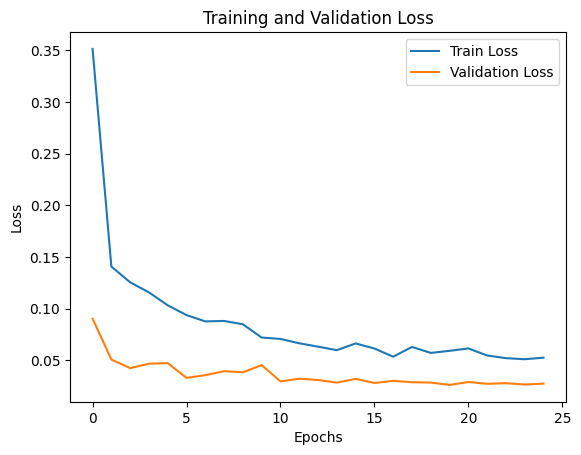

In [ ]:
# Accuracy
plt.plot(modelHistory.history['accuracy'], label = "Train Accuracy")
plt.plot(modelHistory.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


# Loss
plt.plot(modelHistory.history["loss"], label = "Train Loss")
plt.plot(modelHistory.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
from PIL import Image

In [ ]:
img_path = "/content/Satellite Image Classification/data/water/SeaLake_117.jpg"

In [ ]:
img = Image.open(img_path)

print(img.mode)

if img.mode == "CMYK":
    img = img.convert("RGB")

print(img.mode)

img = img.resize((128, 128))

img_array = np.array(img, dtype = np.float32) / 255.0
print(img_array.shape)

img_array = np.expand_dims(img_array, axis = 0)
print(img_array.shape)

RGB
RGB
(128, 128, 3)
(1, 128, 128, 3)


In [ ]:
prediction = cnnModel.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [ ]:
predictedClass = np.argmax(prediction)
predictedClass

3

In [ ]:
classLabels = rawTrainData.class_names
classLabels

['cloudy', 'desert', 'green_area', 'water']

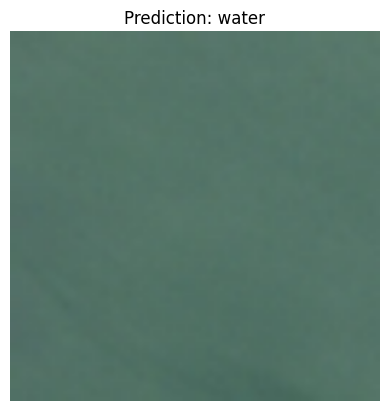

In [ ]:
plt.imshow(img)
plt.title(f"Prediction: {classLabels[predictedClass]}")
plt.axis("off")
plt.show()

In [ ]:
imgSize = (satelliteImgHeight, satelliteImgWidth)
img = image.load_img("/content/Satellite Image Classification/data/cloudy/train_101.jpg", target_size = imgSize)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis = 0)
img_array /= 255.0

predProbs = cnnModel.predict(img_array)
print(dict(zip(classNames, predProbs[0])))

In [ ]:
print(np.max(img_array), np.min(img_array))

0.0033217994 0.0011534026


In [ ]:
print(classLabels)

['cloudy', 'desert', 'green_area', 'water']
